In [2]:
import sys
sys.path.append("..")
sys.path.append("../env")

from env.Cylinder_Rotation_Env import Cylinder_Rotation_Env
import numpy as np
import matplotlib.pyplot as plt 
import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import random_split
from tqdm import tqdm, trange
from fenics import * 
from timeit import default_timer

from models import *
from utils import *

# Environment Initialization

In [3]:
# env init
env = Cylinder_Rotation_Env(params={'dtr': 0.1, 'T': 1, 'rho_0': 1, 'mu' : 1/1000,
                                    'traj_max_T': 20, 'dimx': 128, 'dimy': 64,
                                    'min_x' : 0,  'max_x' : 2.2, 
                                    'min_y' : 0,  'max_y' : 0.41, 
                                    'r' : 0.05,  'center':(0.2, 0.2),
                                    'min_w': -1, 'max_w': 1,
                                    'min_velocity': -1, 'max_velocity': 1,
                                    'U_max': 1.5, })

print(env.params)

# one step: 10 timestamps for dT = 1

# env params
dT = env.params['T']
nx = env.params['dimx']
ny = env.params['dimy']
print('dT: {}, nx: {}, ny: {}'.format(dT, nx, ny))
shape = [nx, ny]

/opt/conda/envs/pytorch-py3.8/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


start init_solve
end init_solve
{'dtr': 0.1, 'T': 1, 'rho_0': 1, 'mu': 0.001, 'traj_max_T': 20, 'dimx': 128, 'dimy': 64, 'min_x': 0, 'max_x': 2.2, 'min_y': 0, 'max_y': 0.41, 'r': 0.05, 'center': (0.2, 0.2), 'min_w': -1, 'max_w': 1, 'min_velocity': -1, 'max_velocity': 1, 'U_max': 1.5}


In [3]:
# plot colors
from matplotlib import colors

cdict = {'red':   ((0.0,  0.22, 0.0),
                   (0.5,  1.0, 1.0),
                   (1.0,  0.89, 1.0)),

         'green': ((0.0,  0.49, 0.0),
                   (0.5,  1.0, 1.0),
                   (1.0,  0.12, 1.0)),

         'blue':  ((0.0,  0.72, 0.0),
                   (0.5,  0.0, 0.0),
                   (1.0,  0.11, 1.0))}

cmap = colors.LinearSegmentedColormap('custom', cdict)

# Global setting

In [22]:
# mosel params setting
L = 2
modes = 16
width = 32
model_params = dict()
model_params['modes'] = modes
model_params['width'] = width
model_params['L'] = L
f_channels = 4

# data path
data_path = './data/nse_data_N0_256_nT_400'

# Phase 1

### Load data

In [57]:
# load data and set params of data
data, _, Cd, Cl, ang_vel = torch.load('data/nse_data_N0_256_nT_400')
print('load data finished')
tg = 10     # sample evrey 10 timestamps
N0 = 256
data = data[:N0, ::tg, :, :, 2:]  
Cd = Cd[:N0, ::tg]
Cl = Cl[:N0, ::tg]
ang_vel = ang_vel[:N0, ::10]

# data param
nx = data.shape[2] 
ny = data.shape[3]
s = data.shape[2] * data.shape[3]   
N0 = data.shape[0]                    # num of data sets
nt = data.shape[1] - 1             # nt

data = data[:, :nt+1, :, :]
Cd = Cd[:, :nt]
Cl = Cl[:, :nt]
ang_vel = ang_vel[:, :nt]
Ndata = N0 * nt

print('N0: {}, nt: {}, ny: {}, nx: {}'.format(N0, nt, ny, nx))

class NSE_Dataset(Dataset):
    def __init__(self, data, Cd, Cl, ang_vel):
        Cd = Cd.reshape(N0, nt, 1, 1, 1).repeat([1, 1, nx, ny, 1]).reshape(-1, nx, ny, 1)
        Cl = Cl.reshape(N0, nt, 1, 1, 1).repeat([1, 1, nx, ny, 1]).reshape(-1, nx, ny, 1)
        ang_vel = ang_vel.reshape(N0, nt, 1, 1, 1).repeat([1, 1, nx, ny, 1]).reshape(-1, nx, ny, 1)
        input_data = data[:, :-1].reshape(-1, nx, ny, 3)
        output_data = data[:, 1:].reshape(-1, nx, ny, 3)

        self.input_data = torch.cat((input_data, ang_vel), dim=-1)
        self.output_data = torch.cat((output_data, Cd, Cl), dim=-1)
        
    def __len__(self):
        return Ndata

    def __getitem__(self, idx):
        x = torch.FloatTensor(self.input_data[idx])
        y = torch.FloatTensor(self.output_data[idx])
        return x, y
        
NSE_data = NSE_Dataset(data, Cd, Cl, ang_vel)
train_data, test_data = random_split(NSE_data, [int(0.8 * Ndata), int(0.2 * Ndata)])

load data finished
N0: 256, nt: 40, ny: 64, nx: 128


### Setting

In [43]:
# output text
ftext = open('./logs/nse_operator_fno_test.txt', 'a', encoding='utf-8')
logs_fname = './logs/nse_operator_fno_test_logs'
logs = dict()

logs['train_loss']=[]
logs['train_loss_f_t_rec']=[]
logs['train_loss_u_t_rec']=[]
logs['train_loss_trans']=[]
logs['train_loss_trans_latent']=[]

logs['test_loss']=[]
logs['test_loss_f_t_rec']=[]
logs['test_loss_u_t_rec']=[]
logs['test_loss_trans']=[]
logs['test_loss_trans_latent']=[]

fname = './logs/nse_operator_fno_test'

In [60]:
# param setting
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

epochs = 1000
batch_size = 256
lr = 1e-2
wd = 1e-4
step_size = 200
gamma = 0.5
# weight = args.weight

lambda1 = 1
lambda2 = 0.1
lambda3 = 0.1
lambda4 = 0.1
f_channels = 4  # setting of text, train, model
print(f'lambda: {lambda1}, {lambda2}, {lambda3}, f_channels: {f_channels}')
ftext.write(f'lambda: {lambda1}, {lambda2}, {lambda3}, f_channels: {f_channels}\n')

print('# Params of phase 1 training')
print(f'epochs: {epochs}\nbatch size: {batch_size}\nlearning rate: {lr}\nweight decay: {wd}\nstep size:{step_size}\ngamma: {gamma}')



lambda: 1, 0.1, 0.1, f_channels: 4
# Params of phase 1 training
epochs: 1000
batch size: 256
learning rate: 0.01
weight decay: 0.0001
step size:200
gamma: 0.5


### Train model

In [62]:
# FNO_ensemble

# model setting
shape = [nx, ny]
model = FNO_ensemble(model_params, shape, f_channels=f_channels).to(device)
params_num = count_params(model)
print(f'param numbers of the model: {params_num}')
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False)

# train model
pbar = tqdm(total=epochs, file=sys.stdout)
for epoch in range(1, epochs+1):
    model.train()
    
    t1 = default_timer()
    train_loss = AverageMeter()
    train_loss1 = AverageMeter()
    train_loss2 = AverageMeter()
    train_loss3 = AverageMeter()
    train_loss4 = AverageMeter()
    test_loss = AverageMeter()
    test_loss1 = AverageMeter()
    test_loss2 = AverageMeter()
    test_loss3 = AverageMeter()
    test_loss4 = AverageMeter()

    for x_train, y_train in train_loader:
        x_train, y_train = x_train.to(device), y_train.to(device)
        
        optimizer.zero_grad()

        # split data read in train_loader
        in_train, f_train = x_train[:, :, :, :-1], x_train[:, 0, 0, -1]
        out_train, Cd_train, Cl_train = y_train[:, :, :, :-2], y_train[:, 0, 0, -2], y_train[:, 0, 0, -1]
        # put data into model
        pred, x_rec, f_rec, trans_out = model(in_train, f_train)
        out_latent = model.stat_en(out_train)
        in_rec = x_rec[:, :, :, :3]
        # prediction items
        out_pred = pred[:, :, :, :3]
        Cd_pred = torch.mean(pred[:, :, :, -2].reshape(batch_size, -1), 1)
        Cl_pred = torch.mean(pred[:, :, :, -1].reshape(batch_size, -1), 1)

        # loss1: prediction loss; loss2: rec loss of state
        # loss3: rec loss of f; loss4: latent loss
        loss1 = rel_error(out_pred, out_train).mean()\
                + rel_error(Cd_pred, Cd_train).mean()\
                + rel_error(Cl_pred, Cl_train).mean()
        # loss1 = F.mse_loss(out_pred, out_train, reduction='mean')\
        #         + F.mse_loss(Cd_pred, Cd_train, reduction='mean')\
        #         + F.mse_loss(Cl_pred, Cl_train, reduction='mean')
        loss2 = rel_error(in_rec, in_train).mean()
        loss3 = rel_error(f_rec, f_train).mean()
        # loss3 = F.mse_loss(f_rec, f_train, reduction='mean')
        loss4 = rel_error(trans_out, out_latent).mean()
        # loss4 = F.mse_loss(trans_out, out_latent, reduction='mean')
        loss = lambda1 * loss1 + lambda2 * loss2 + lambda3 * loss3 + lambda4 * loss4
        
        loss.backward()
        optimizer.step()

        train_loss.update(loss.item(), x_train.shape[0])
        train_loss1.update(loss1.item(), x_train.shape[0])
        train_loss2.update(loss2.item(), x_train.shape[0])
        train_loss3.update(loss3.item(), x_train.shape[0])
        train_loss4.update(loss4.item(), x_train.shape[0])
    
    logs['train_loss'].append(train_loss.avg)
    logs['train_loss_f_t_rec'].append(train_loss3.avg)
    logs['train_loss_u_t_rec'].append(train_loss2.avg)
    logs['train_loss_trans'].append(train_loss1.avg)
    logs['train_loss_trans_latent'].append(train_loss4.avg)
    
    scheduler.step()
    model.eval()

    with torch.no_grad():
        for x_test, y_test in test_loader:
            x_test, y_test = x_test.to(device), y_test.to(device)

            # split data read in test_loader
            in_test, f_test = x_test[:, :, :, :-1], x_test[:, 0, 0, -1]
            out_test, Cd_test, Cl_test = y_test[:, :, :, :-2], y_test[:, 0, 0, -2], y_test[:, 0, 0, -1]
            # put data into model
            pred, x_rec, f_rec, trans_out = model(in_test, f_test)
            out_latent = model.stat_en(out_test)
            in_rec = x_rec[:, :, :, :3]
            # prediction items
            out_pred = pred[:, :, :, :3]
            Cd_pred = torch.mean(pred[:, :, :, 3].reshape(batch_size, -1), 1)
            Cl_pred = torch.mean(pred[:, :, :, 4].reshape(batch_size, -1), 1)
            loss1 = rel_error(out_pred, out_test).mean()\
                    + rel_error(Cd_pred, Cd_test).mean()\
                    + rel_error(Cl_pred, Cl_test).mean()
            loss2 = rel_error(in_rec, in_test).mean()
            loss3 = rel_error(f_rec, f_test).mean()
            loss4 = rel_error(trans_out, out_latent).mean()
            loss = lambda1 * loss1 + lambda2 * loss2 + lambda3 * loss3 + lambda4 * loss4

            test_loss.update(loss.item(), x_test.shape[0])
            test_loss1.update(loss1.item(), x_test.shape[0])
            test_loss2.update(loss2.item(), x_test.shape[0])
            test_loss3.update(loss3.item(), x_test.shape[0])
            test_loss4.update(loss4.item(), x_test.shape[0])
        
        logs['test_loss'].append(test_loss.avg)
        logs['test_loss_f_t_rec'].append(test_loss3.avg)
        logs['test_loss_u_t_rec'].append(test_loss2.avg)
        logs['test_loss_trans'].append(test_loss1.avg)
        logs['test_loss_trans_latent'].append(test_loss4.avg)
            
    t2 = default_timer()

    ftext.write('# {} | (train) loss1: {:1.2e}  loss2: {:1.2e}  loss3: {:1.2e} loss4: {:1.2e} | (test) loss1: {:1.2e} loss2: {:1.2e}  loss3: {:1.2e} loss4: {:1.2e}\n'
                .format(epoch, train_loss1.avg, train_loss2.avg, train_loss3.avg, train_loss4.avg, test_loss1.avg, test_loss2.avg, test_loss3.avg, test_loss4.avg))
    
    end = '\r'
    pbar.set_description('# {} | loss1: {:1.2e}  loss2: {:1.2e}  loss3: {:1.2e} loss4: {:1.2e} | loss1: {:1.2e} loss2: {:1.2e}  loss3: {:1.2e} loss4: {:1.2e}'
                            .format(epoch, train_loss1.avg, train_loss2.avg, train_loss3.avg, train_loss4.avg, test_loss1.avg, test_loss2.avg, test_loss3.avg, test_loss4.avg))
    pbar.update()

torch.save(model.state_dict(), fname)
torch.save(logs, logs_fname)

param numbers of the model: 858522
  0%|          | 0/1000 [00:22<?, ?it/s]


RuntimeError: CUDA out of memory. Tried to allocate 512.00 MiB (GPU 0; 14.76 GiB total capacity; 13.00 GiB already allocated; 244.94 MiB free; 13.34 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [39]:
# FNO

# model setting
model = FNO(modes, modes, width, L).to(device)
params_num = count_params(model)
print(f'param numbers of the model: {params_num}')
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

# train model FNO
pbar = tqdm(total=epochs, file=sys.stdout)
for epoch in range(1, epochs+1):
    model.train()
    
    t1 = default_timer()
    train_loss1 = AverageMeter()
    train_loss2 = AverageMeter()
    test_loss1 = AverageMeter()
    test_loss2 = AverageMeter()

    for x_train, y_train in train_loader:
        x_train, y_train = x_train.to(device), y_train.to(device)
        
        optimizer.zero_grad()

        in_train, f_train = x_train[:, :, :, :3], x_train[:, 0, 0, 3]
        out_train, Cd_train, Cl_train = y_train[:, :, :, :3], y_train[:, 0, 0, 3], y_train[:, 0, 0, 4]
        out_pred, Cd_pred, Cl_pred = model(in_train, f_train)
        # loss1 = F.mse_loss(out_pred, out_train, reduction='mean')
        loss1 = rel_error(out_pred, out_train).mean()
        # loss2 = F.mse_loss(Cd_pred, Cd_train, reduction='mean') + F.mse_loss(Cl_pred, Cl_train, reduction='mean')
        loss2 = rel_error(Cd_pred, Cd_train).mean() + rel_error(Cl_pred, Cl_train).mean()
        loss = loss1 + loss2
        loss.backward()

        optimizer.step()

        train_loss1.update(loss1.item(), x_train.shape[0])
        train_loss2.update(loss2.item(), x_train.shape[0])
    
    scheduler.step()

    model.eval()
    with torch.no_grad():
        for x_test, y_test in test_loader:
            x_test, y_test = x_test.to(device), y_test.to(device)

            in_test, f_test = x_test[:, :, :, :3], x_test[:, 0, 0, 3]
            out_test, Cd_test, Cl_test = y_test[:, :, :, :3], y_test[:, 0, 0, 3], y_test[:, 0, 0, 4]
            out_pred, Cd_pred, Cl_pred = model(in_test, f_test)
            loss1 = rel_error(out_pred, out_test).mean()
            loss2 = rel_error(Cd_pred, Cd_test).mean() + rel_error(Cl_pred, Cl_test).mean()
            loss = loss1 + loss2

            test_loss1.update(loss1.item(), x_test.shape[0])
            test_loss2.update(loss2.item(), x_test.shape[0])
        
    t2 = default_timer()
    
    end = '\r'
    pbar.set_description('epoch {} | (time) epoch_time: {:1.3f} | (train) loss1: {:1.2e},  loss2: {:1.2e} | (test) loss1: {:1.2e}, loss2: {:1.2e}'
                            .format(epoch, t2-t1, train_loss1.avg, train_loss2.avg, test_loss1.avg, test_loss2.avg))
    pbar.update()
    
# if not os.path.exists('./logs/{}'.format(args.name)):
#     os.mkdir('./logs/{}'.format(args.name))
torch.save(model.state_dict(), fname)

param numbers of the model: 465953
epoch 35 | (time) epoch_time: 0.231 | (train) loss1: 1.20e-01,  loss2: 2.71e-01 | (test) loss1: 1.14e-01, loss2: 2.99e-01:   4%|▎         | 35/1000 [00:11<05:10,  3.11it/s]
epoch 1000 | (time) epoch_time: 0.302 | (train) loss1: 1.13e-02,  loss2: 1.71e-02 | (test) loss1: 2.28e-02, loss2: 4.41e-02: 100%|██████████| 1000/1000 [07:09<00:00,  3.61it/s]

### Plot show

dict_keys(['args', 'train_loss', 'train_loss_f_t_rec', 'train_loss_u_t_rec', 'train_loss_trans', 'train_loss_trans_latent', 'test_loss', 'test_loss_f_t_rec', 'test_loss_u_t_rec', 'test_loss_trans', 'test_loss_trans_latent'])
Namespace(L=2, Ng=1, batch_size=64, epochs=1000, f_channels=4, gamma=0.5, gpu=0, lambda1=10.0, lambda2=0.1, lambda3=0.01, lambda4=1.0, lr=0.001, modes=16, name='nse_operator_fno_test', step_size=200, tg=20, wd=0.0001, width=32)


(0.0, 0.5)

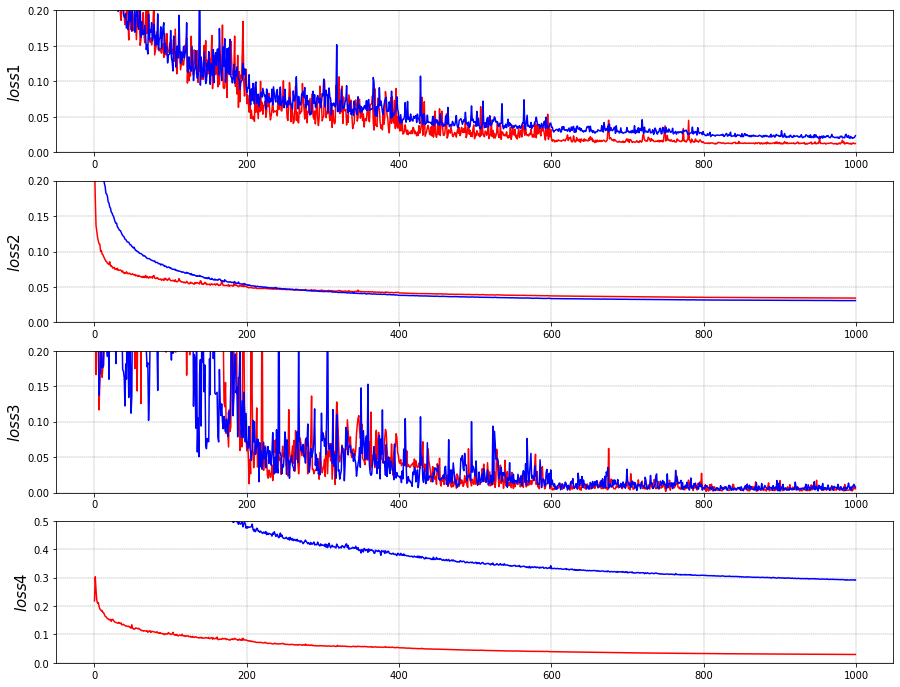

In [20]:
# load logs
_, logs = torch.load('logs/phase1_logs_ex12')
print(logs.keys())
print(logs['args'])
loss1, loss2, loss3, loss4 = logs['test_loss_trans'], logs['test_loss_u_t_rec'], logs['test_loss_f_t_rec'], logs['test_loss_trans_latent']

plt.figure(figsize=(15, 12))
ax1 = plt.subplot2grid((4, 2), (0, 0), colspan=2)
ax2 = plt.subplot2grid((4, 2), (1, 0), colspan=2)
ax3 = plt.subplot2grid((4, 2), (2, 0), colspan=2)
ax4 = plt.subplot2grid((4, 2), (3, 0), colspan=2)

ax1.plot(loss1, color='red')
ax1.grid(True, lw=0.4, ls="--", c=".50")
ax1.set_ylabel(r"$loss1$", fontsize=15)

ax2.plot(loss2, color='red')
ax2.grid(True, lw=0.4, ls="--", c=".50")
ax2.set_ylabel(r"$loss2$", fontsize=15)

ax3.plot(loss3, color='red')
ax3.grid(True, lw=0.4, ls="--", c=".50")
ax3.set_ylabel(r"$loss3$", fontsize=15)

ax4.plot(loss4, color='red')
ax4.grid(True, lw=0.4, ls="--", c=".50")
ax4.set_ylabel(r"$loss4$", fontsize=15)

# load logs
_, logs = torch.load('logs/phase1_logs_ex11')
loss1, loss2, loss3, loss4 = logs['test_loss_trans'], logs['test_loss_u_t_rec'], logs['test_loss_f_t_rec'], logs['test_loss_trans_latent']

ax1.plot(loss1, color='blue')
ax2.plot(loss2, color='blue')
ax3.plot(loss3, color='blue')
ax4.plot(loss4, color='blue')

# ax1.set_xlim(0, 1000)
ax1.set_ylim(0, 0.2) 
# ax2.set_xlim(0, 1000)
ax2.set_ylim(0, 0.2)
# ax3.set_xlim(0, 1000)
ax3.set_ylim(0, 0.2)
# ax4.set_xlim(0, 1000)
ax4.set_ylim(0, 0.5)

In [103]:
par = logs['args']
print(par)
print(par.f_channels)
print(par.modes)
print(par.L)
print(par.tg)

Namespace(L=2, Ng=1, batch_size=64, epochs=1000, f_channels=4, gamma=0.5, gpu=0, lambda1=1, lambda2=0.1, lambda3=0.01, lambda4=0.1, lr=0.001, modes=16, name='nse_operator_fno_test', step_size=100, tg=20, wd=0.0001, width=32)
4
16
2
20


tensor([-2.0000, -2.0000, -2.0000, -2.0000, -2.0000, -2.0000, -2.0000, -2.0000,
        -2.0000, -2.0000, -1.2500, -1.2500, -1.2500, -1.2500, -1.2500, -1.2500,
        -1.2500, -1.2500, -1.2500, -1.2500])
tensor([0.0000, 2.9248, 2.8747, 2.8742, 2.8839, 2.9356, 2.9998, 3.0145, 3.0471,
        3.0505, 3.1021, 3.1085, 3.0528, 3.0910, 3.1318, 3.1253, 3.1124, 3.0718,
        3.1304, 3.1514])
tensor([2.6156, 2.9252, 2.8703, 2.8760, 2.8830, 2.9392, 3.0037, 3.0150, 3.0477,
        3.0498, 3.1024, 3.1142, 3.0568, 3.0960, 3.1318, 3.1269, 3.1091, 3.0730,
        3.1358, 3.1563])


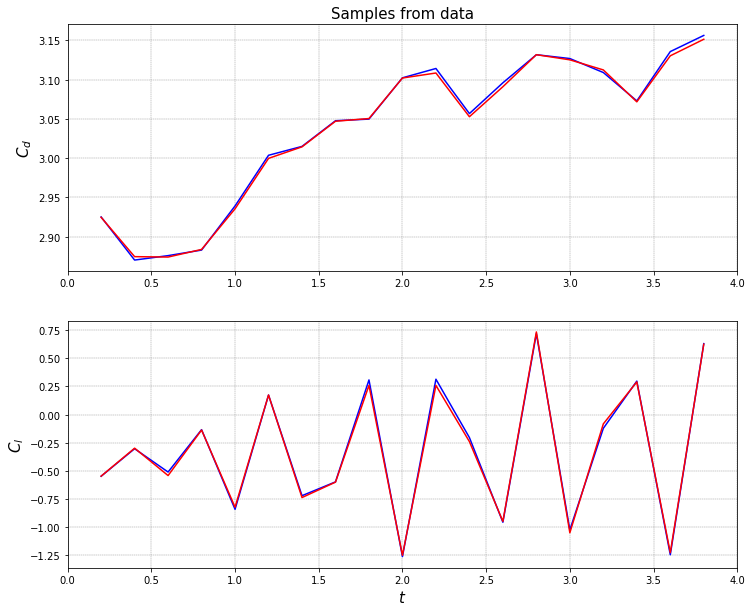

In [32]:
# load logs
data, _, Cd, Cl, ang_vel  = torch.load(data_path)
tg = 20     # sample evrey 10 timestamps
Ng = 1
data = data[::Ng, ::tg, :, :, 2:]  
Cd = Cd[::Ng, ::tg]
Cl = Cl[::Ng, ::tg]
ang_vel = ang_vel[::Ng, ::tg]

# data param
nx = data.shape[2] 
ny = data.shape[3]
shape = [nx, ny]
s = data.shape[2] * data.shape[3]     # ny * nx
N0 = data.shape[0]                    # num of data sets
nt = data.shape[1] - 1             # nt
t = np.arange(nt) * 0.2

t_start = 1
k = 3   # k th traj
print(ang_vel[k])

# model
operator_path = 'logs/phase1_logs_ex12'
load_model = FNO_ensemble(model_params, shape, f_channels=f_channels)
state_dict, _ = torch.load(operator_path)
load_model.load_state_dict(state_dict)
load_model.eval()

for param in list(load_model.parameters()):
    param.requires_grad = False

data_in = data[k].squeeze()[t_start]
out_nn = data_in.reshape(nx, ny, 3)
Cd_nn = torch.zeros(nt)
Cl_nn = torch.zeros(nt)
f = ang_vel[k]

out_nn = data_in.reshape(1, nx, ny, 3)
for i in range(t_start, nt):
    f_nn = f[i].reshape(1)
    pred, _, _, _ = load_model(out_nn, f_nn)
    out_nn = pred[:, :, :, :3]
    Cd_nn[i] = torch.mean(pred[:, :, :, -2])
    Cl_nn[i] = torch.mean(pred[:, :, :, -1])

print(Cd_nn)
print(Cd[k])

plt.figure(figsize=(12,10))
ax1 = plt.subplot2grid((2, 2), (0, 0), colspan=2)
ax2 = plt.subplot2grid((2, 2), (1, 0), colspan=2)

ax1.set_title('Samples from data', size=15)
ax1.plot(t[t_start:], Cd[k][t_start:], color='blue')
ax1.grid(True, lw=0.4, ls="--", c=".50")
ax1.set_xlim(0, 4)
ax1.set_ylabel(r"$C_d$", fontsize=15)

ax2.plot(t[t_start:], Cl[k][t_start:], color='blue')
ax2.grid(True, lw=0.4, ls="--", c=".50")
ax2.set_ylabel(r"$C_l$", fontsize=15)
ax2.set_xlabel(r"$t$", fontsize=15)
ax2.set_xlim(0, 4)
ax1.plot(t[t_start:], Cd_nn[t_start:], color='red')
ax2.plot(t[t_start:], Cl_nn[t_start:], color='red')
# ax1.set_xlim(0, 2)
# ax1.set_ylim(0, 4)
# ax2.set_xlim(0, 2)
# ax2.set_ylim(-2, 2)

# Phase 2

### Setting

In [12]:
# param and operator path setting
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
operator_path = './logs/nse_operator_fno_test'

lr = 5e-1
epochs = 1000
step_size = 100
gamma = 0.8

### Load data and model setting

In [48]:
# load_data
data_num = 0
data, _, Cd, Cl, ang_vel = torch.load(data_path, map_location=lambda storage, loc: storage)
data_in = data[data_num].squeeze()[0].to(device)
data_fin = data[data_num].squeeze()[0].to(device)

# data params
ny = data.shape[2] 
nx = data.shape[3]
s = data.shape[2] * data.shape[3]     # ny * nx
N0 = data.shape[0]                    # num of data sets
nt = data.shape[1] - 1                # nt
print('N0: {}, nt: {}, ny: {}, nx: {}'.format(N0, nt, ny, nx))

# load model
load_model = FNO_ensemble(modes, modes, width, L).to(device)
state_dict = torch.load(operator_path)
load_model.load_state_dict(state_dict)
load_model.eval()

for param in list(load_model.parameters()):
    param.requires_grad = False

# set policy net
# p_net = torch.nn.ModuleList([policy_net_cnn().to(device) for _ in range(nt)])
p_net = policy_net_cnn().to(device)

# training
optimizer = torch.optim.Adam(p_net.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

N0: 25, nt: 99, ny: 128, nx: 64


### Train model

In [ ]:
# start train model of phase2 with env
ftext = open('logs/phase2&env.txt', mode="a", encoding="utf-8")
ftext.write(f"phase2&env | data_num: {data_num}")
ftext.write('N0: {}, nt: {}, ny: {}, nx: {}'.format(N0, nt, ny, nx))

for epoch in range(1, epochs + 1):
    env.reset()

    p_net.train()
    optimizer.zero_grad()

    ang_optim = torch.rand(nt).to(device)
    out_nn = data_in.reshape(ny, nx, 3).to(device)
    Cd_nn = torch.zeros(nt).to(device)
    Cl_nn = torch.zeros(nt).to(device)
    Cd_obs = torch.zeros(nt).to(device)
    Cl_obs = torch.zeros(nt).to(device)
    for i in range(nt):
        # print('ang_optim[i]: {}'.format(ang_optim[i].size()))
        # ang_optim[i] = p_net(out_nn.reshape(1, -1))
        ang_optim[i] = p_net[i](out_nn.reshape(1, ny, nx, 3))
        ang_nn = ang_optim[i].reshape(1, 1, 1).repeat(ny, nx, 1)
        in_nn = torch.cat((out_nn.squeeze(), ang_nn), dim=-1).unsqueeze(0)
        out_nn, Cd_nn[i], Cl_nn[i] = load_model(in_nn)
        ang_obs = ang_optim[i].to(torch.device('cpu')).detach().numpy()
        out_obs, _, Cd_obs[i], Cl_obs[i] = env.step(ang_obs)
        # print(f"epoch: {epoch} | Cd_nn: {Cd_nn} | Cl_nn: {Cl_nn} | i: {i}")
    

    loss = torch.mean(Cd_nn ** 2) + 0.1 * torch.mean(Cl_nn ** 2)
    loss += 0.01 * torch.mean(ang_optim.squeeze() ** 2)
    print("epoch: {:4}  loss: {:1.6f}  Cd_nn: {:1.6f}  Cd_obs: {:1.6f}  Cl_nn: {:1.6f}  Cl_obs: {:1.6f}  ang_optim: {:1.6f}"
            .format(epoch, loss, Cd_nn.mean(), Cd_obs.mean(), Cl_nn.mean(), Cl_obs.mean(), ang_optim.mean()))

    loss.backward()
    optimizer.step()
    scheduler.step()
    
    # save log
    ftext.write("epoch: {:4}  loss: {:1.6f}  Cd_nn: {:1.6f}  Cd_obs: {:1.6f}  Cl_nn: {:1.6f}  Cl_obs: {:1.6f}  ang_optim: {:1.6f}"
                .format(epoch, loss, Cd_nn.mean(), Cd_obs.mean(), Cl_nn.mean(), Cl_obs.mean(), ang_optim.mean()))
ftext.close()


# Some test

### no f 

MovieWriter ffmpeg unavailable; using Pillow instead.


(401, 128, 64, 5)
end


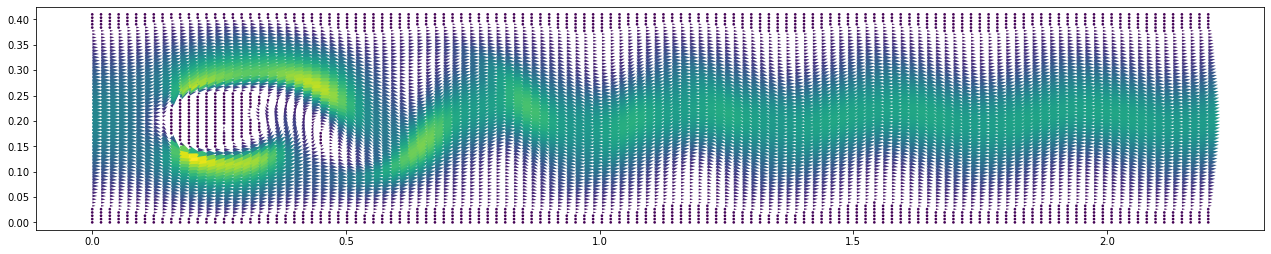

In [27]:
import matplotlib.animation as animation
data_orig = torch.load('data/baseline_dt_0.01_T_4')
obs_orig, _, _, _, _ = data_orig
obs_orig = obs_orig[3].numpy()
print(obs_orig.shape)

x, y, u, v = [obs_orig[:, :, :, i] for i in range(4)]
w = u**2 + v**2
xl, xh  = np.min(x), np.max(x)
yl, yh = np.min(y), np.max(y)

figsizer=10
fig, ax = plt.subplots( figsize=((xh - xl)*figsizer,(yh-yl)*figsizer))
ax.axis('equal')
# ax.set(xlim=(0, 2.2), ylim=(0, 0.41))
ax.set(xlim=(xl, xh), ylim=(yl, yh))
# ax.quiver(x, y, u, v, w)
print('end')

def animate(i):
    ax.clear()
    ax.quiver(x[i], y[i], u[i], v[i], w[i])
    # ax.plot(x[i], y[i])

myAnimation = animation.FuncAnimation(fig, animate, frames=np.arange(400), interval=10, repeat=False)
myAnimation.save('test1.gif')
# plt.show()

### show plot of given f

MovieWriter ffmpeg unavailable; using Pillow instead.


(401, 128, 64, 5)
end


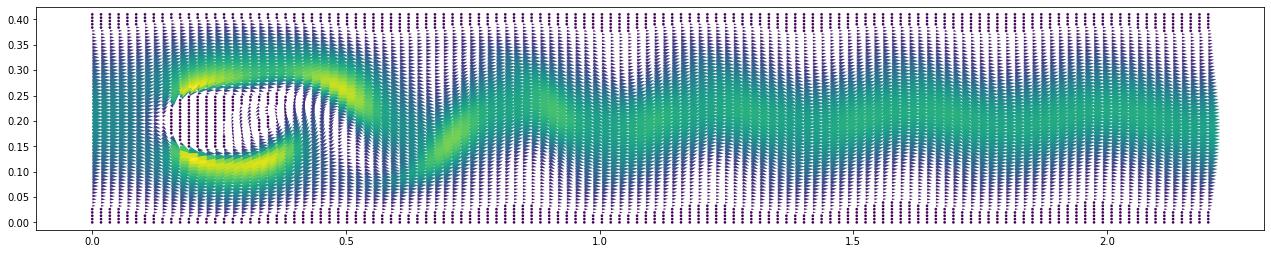

In [31]:
data = torch.load('data/nse_data_control_test')
obs, _, _, _ = data
obs = obs.numpy()
print(obs.shape)

x, y, u, v = [obs[:, :, :, i] for i in range(4)]
w = u**2 + v**2
xl, xh  = np.min(x), np.max(x)
yl, yh = np.min(y), np.max(y)

figsizer=10
fig, ax = plt.subplots( figsize=((xh - xl)*figsizer,(yh-yl)*figsizer))
ax.axis('equal')
# ax.set(xlim=(0, 2.2), ylim=(0, 0.41))
ax.set(xlim=(xl, xh), ylim=(yl, yh))
# ax.quiver(x, y, u, v, w)
print('end')

def animate(i):
    ax.clear()
    ax.quiver(x[i], y[i], u[i], v[i], w[i])
    # ax.plot(x[i], y[i])

myAnimation = animation.FuncAnimation(fig, animate, interval=5, repeat=False)
myAnimation.save('test2.gif')
# plt.show()

(20, 128, 64, 3)
(20, 128, 64, 3)


(0.0, 4.0)

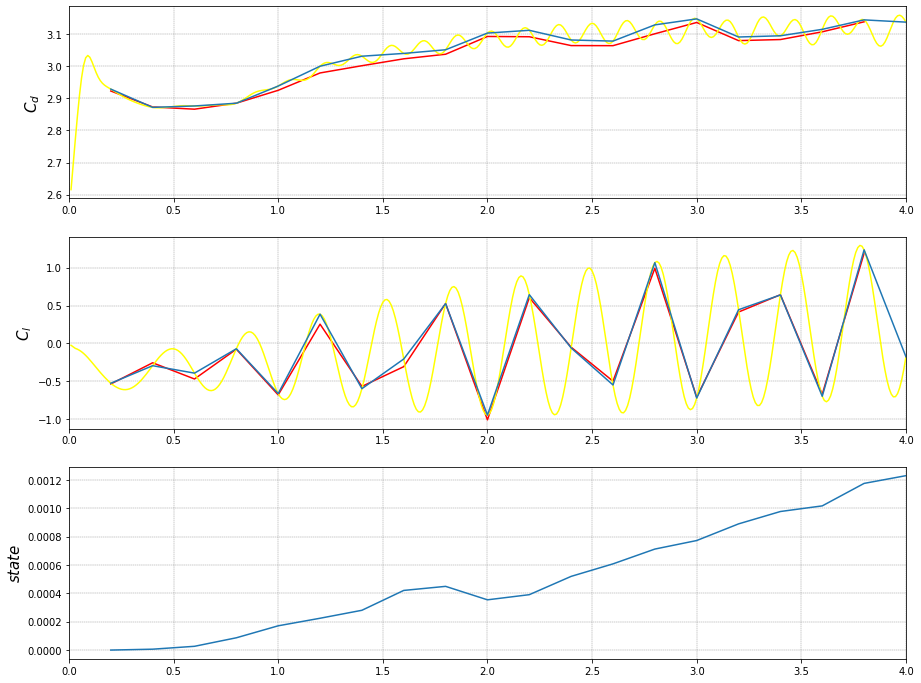

In [62]:
# load_data
obs, Cd, Cl, obs_nn, Cd_nn, Cl_nn = torch.load('logs/phase1_env_logs', map_location=lambda storage, loc: storage)

t_start = 1
nt = 400

plt.figure(figsize=(15, 12))

ax1 = plt.subplot2grid((3, 2), (0, 0), colspan=2)
ax2 = plt.subplot2grid((3, 2), (1, 0), colspan=2)
ax3 = plt.subplot2grid((3, 2), (2, 0), colspan=2)

t = (np.arange(nt) + 1) * 0.01
t_nn = (np.arange(nt//20) + 1) * 0.2

ax1.plot(t_nn[:-1], Cd_nn[t_start:], color='red')
ax1.plot(t, Cd, color='yellow')
ax1.plot(t_nn, Cd[19::20])
ax1.grid(True, lw=0.4, ls="--", c=".50")
ax1.set_ylabel(r"$C_d$", fontsize=15)
ax1.set_xlim(0, 4)

ax2.plot(t_nn[:-1], Cl_nn[t_start:], color='red')
ax2.plot(t, Cl, color='yellow')
ax2.plot(t_nn, Cl[19::20])
ax2.grid(True, lw=0.4, ls="--", c=".50")
ax2.set_ylabel(r"$C_l$", fontsize=15)
ax2.set_xlim(0, 4)

obs_sps = obs[::20][1:][...,2:]
print(obs_sps.shape)
obs_nn = obs_nn.detach().numpy()
print(obs_nn.shape)
obs_var = obs_sps - obs_nn
obs_var = np.mean((obs_var.reshape(20, -1)**2), 1)
ax3.plot(t_nn, obs_var)
ax3.grid(True, lw=0.4, ls="--", c=".50")
ax3.set_ylabel(r"$state$", fontsize=15)
ax3.set_xlim(0, 4)

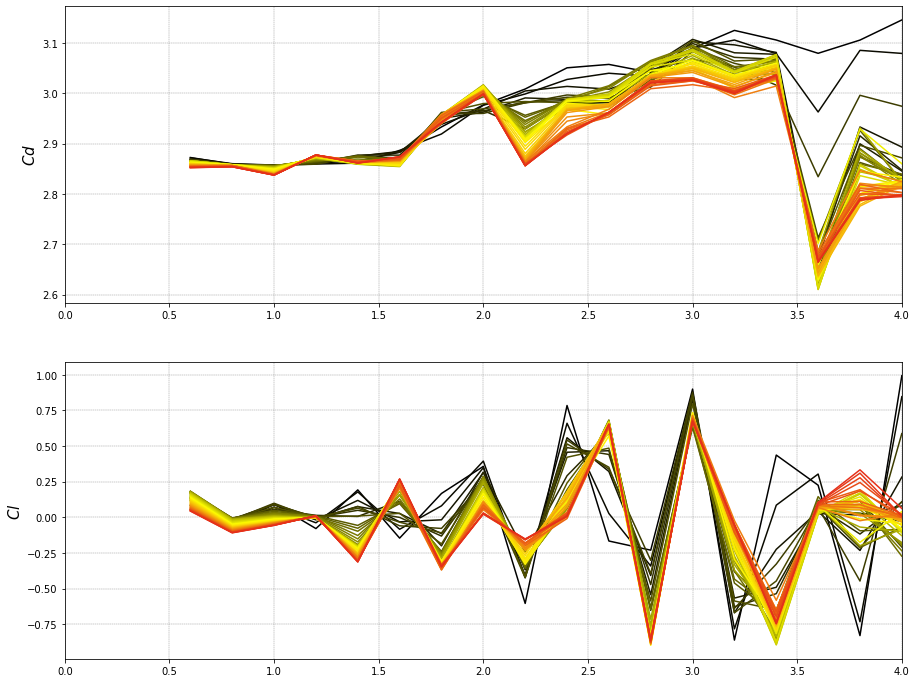

In [47]:
logs = torch.load('logs/phase2_logs_test')
Cd_nn = logs['Cd_nn']
Cl_nn = logs['Cl_nn']

Nk = 50
k = np.arange(Nk)*10
t_start = 2

plt.figure(figsize=(15, 12))

ax1 = plt.subplot2grid((2, 2), (0, 0), colspan=2)
ax2 = plt.subplot2grid((2, 2), (1, 0), colspan=2)

t_nn = (np.arange(20) + 1) * 0.2

for i in range(Nk):
    Cd = Cd_nn[i].to(torch.device('cpu')).detach().numpy()
    Cl = Cl_nn[i].to(torch.device('cpu')).detach().numpy()

    ax1.plot(t_nn[t_start:], Cd[t_start:], color = cmap(i/(Nk+1)))
    ax1.grid(True, lw=0.4, ls="--", c=".50")
    ax1.set_ylabel(r"$Cd$", fontsize=15)
    ax1.set_xlim(0, 4)

    ax2.plot(t_nn[t_start:], Cl[t_start:], color = cmap(i/(Nk+1)))
    ax2.grid(True, lw=0.4, ls="--", c=".50")
    ax2.set_ylabel(r"$Cl$", fontsize=15)
    ax2.set_xlim(0, 4)
